In [3]:
from google.colab import drive
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
import scipy
import sklearn

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/DATA')

Mounted at /content/drive


In [4]:
print("numpy version " + np.__version__)
print("pandas version " + pd.__version__)
print("tensorflow version " + tf.__version__)
print("keras version " + keras.__version__)
print("scipy version " + scipy.__version__)
print("sklearn version " + sklearn.__version__)

numpy version 1.19.5
pandas version 1.1.5
tensorflow version 2.5.0
keras version 2.5.0
scipy version 1.4.1
sklearn version 0.22.2.post1


In [5]:
import tensorflow as tf
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [6]:
!nvidia-smi
# 실시간 메모리 체크

Tue Jun  8 11:51:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    26W /  70W |    222MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Load Data

In [7]:
import pandas as pd
import numpy as np
pd.set_option("display.max_column", 600)
pd.set_option("display.max_row", 600)

import warnings
warnings.filterwarnings("ignore")

path = os.getcwd()

train = pd.read_csv(path + "/train_features.csv")

# acc와 gy 값을 각각 저장
train_acc, train_gy  = train.iloc[:, 2:5], train.iloc[:, 5:]

# train.time => time 컬럼 값만
# 값을 0~599까지만 사용하고 50으로 나눔
# get_cumtrapz 함수에서 사용
train_time = train.time[:600]/50

train_label = pd.read_csv(path + "/train_labels.csv")
# label 컬럼 값만
train_y = train_label.label

test = pd.read_csv(path + "/test_features.csv")
submission = pd.read_csv(path + "/sample_submission.csv")

### Data Aug

DACON.Dobby님께서 공유해주신 time rolling을 이용했습니다.  
논문에서 다양한 augmentation 방법을 찾을 수 있었는데 그 중에서 rotation과 permutation 기법을 이용했습니다.  
rotation은 wearable센서의 무작위한 착용 방향을 고려한 데이터 증강 방법입니다.  
permutation은 신호를 n segment로 나누어 순서를 랜덤하게 바꿔주는 방법입니다.

In [8]:
# scipy.integrate: 수치적분 루틴과 미분방정식 해법기
# scipy.linalg: numpy.linalg에서 제공하는 것보다 더 확장된 선형대수 루틴과 매트릭스 분해
# scipy.optimize: 함수 최적화기와 방정식의 근을 구하는 알고리즘
# scipy.signal: 시그널 프로세싱 도구
# scipy.sparse: 희소 행렬과 희소 선형 시스템 풀이법
# scipy.special: 감마 함수처럼 흔히 사용되는 수학 함수를 구현한 포트란 라이브러리인 SPECFUN 확장
# scipy.stats: 표준 연속/이산 확률 분포(집적도 함수, 샘플러, 연속 분포 함수)와 다양한 통계 테스트, 그리고 좀 더 기술적인 통계 도구
# scipy.weave: 배열 계산을 빠르게 하기 위해 인라인 C++ 코드를 사용하는 도구

In [9]:
pip install transforms3d

     |████████████████████████████████| 71kB 5.3MB/s 
  Created wheel for transforms3d: filename=transforms3d-0.3.1-cp37-none-any.whl size=59374 sha256=f718590601c02b170608f1d80f896f79c5a24a3413b79811dcaf77d4025f2436
  Stored in directory: /root/.cache/pip/wheels/3d/3c/84/28d36677f3c760c048bd02b5a547ea0c4027770cc9cdb9af1e
Successfully built transforms3d


In [10]:
import scipy
from transforms3d.axangles import axangle2mat

def rolling(data):
    # shape[0] => 행 수 
    # random.choice(x,y) => x보다 작은 수로, y개만큼 랜덤 생성
    for j in np.random.choice(data.shape[0], int(data.shape[0]*2/3)):
        # np.roll => 재배열
        # np.roll(x,y,axis = 0) => x라는 np배열을 y개만큼씩 미룬다
        # np.random.choice(data.shaple[1]) , data.shape[1]=> 컬럼 수
        #  => 0~컬럼수-1 중에서 랜덤으로 추출해서 그만큼 배열을 밀어서 재배열 (axis는 차원)
        data[j] = np.roll(data[j], np.random.choice(data.shape[1]), axis= 0)
    return data

def rotation(data):
    # np.random.uniform(low, high, size)
    # 최소값 low~ 최대값 high인 구간에서의 균등분포에서 size개의 난수 생성
    # axis => -1~1 구간에서 data의 컬럼 개수만큼의 난수 생성
    axis = np.random.uniform(low=-1, high=1, size=data.shape[1])
    # angle => -np.pi~pi 구간에서 1개의 난수 생성
    angle = np.random.uniform(low=-np.pi, high=np.pi)
    # np.matmul => 2D의 경우 기존 행렬 곱
    # 두 인수 중 하나가 nD의 경우(n>2), 마지막 두개의 축으로 이루어진 행렬을 나머지 축에 따라 쌓아 놓은 것이라고 생각한다.
    # 즉, 마지막 두개의 행렬을 제외한 행렬의 크기가 일치하여야 한다.
    # axangle2mat(축,각도) => 회전 각도에 대한 회전 행렬 각도 주위에서 축
    return np.matmul(data , axangle2mat(axis,angle))

def permutation(data, nPerm=4, mSL=10):
    # np.zeros => 0으로 가득찬 Array 생성
    # data.shape는 (row,col) 형태기 때문에 2차원으로 생성됨
    data_new = np.zeros(data.shape)
    # np.random.permutation(x) => x까지의 숫자를 가진 무작위 배열 생성
    # nPerm은 4로 지정되어있기 때문에 0~3로 크기가 4인 배열 생성
    idx = np.random.permutation(nPerm)
    bWhile = True
    while bWhile == True:
        # 크기가 5인 0으로 이루어진 배열 생성
        segs = np.zeros(nPerm+1, dtype=int)
        # 처음과 마지막을 제외한 원소들을 랜덤하게 채워넣음
        # 최소값 => mSL=10
        # 최대값 => data.shaple[0]-mSL => data 배열의 row 수 - 10
        # 사이즈 => nPerm-1 => 3 (크기가 5인 배열에서 처음, 마지막을 제외하니까)
        # 정렬해서 대입
        segs[1:-1] = np.sort(np.random.randint(mSL, data.shape[0]-mSL, nPerm-1))
        # 마지막 원소는 data의 row수 대입
        segs[-1] = data.shape[0]

        # [1:] - [0:-1] => 2~5번째, 1~4번째를 각각 뺀다
        # 그 중 제일 작은 값이 mSL보다 크면 변수를 false로 바꿔서 무한루프 종료 
        if np.min(segs[1:]-segs[0:-1]) > mSL:
            bWhile = False
    # 어디에 사용하는 변수일까? 나중에
    pp = 0
    for ii in range(nPerm):
        # idx는 위에서 선언한 0~3이 랜덤으로 들어간 크기가 4인 배열
        # data의 segs[idx[ii]]번째 행 전체를 data_temp에 저장 
        data_temp = data[segs[idx[ii]]:segs[idx[ii]+1],:]
        # data_new는 위에서 2차원으로 생성한 0으로 이루어진 배열 (data의 row,col에 맞춰서) 
        # data_new의 pp번째 행에 data_temp 대입
        data_new[pp:pp+len(data_temp),:] = data_temp
        pp += len(data_temp)
    return(data_new)

def combine_aug(data, k, aug_P = 0):
    data_ = data.copy()
    if aug_P == 0:
        # rotation 함수 적용
        if (k+1) % 2 == 0:
            for i in np.random.choice(int(data.shape[0]/600), int(data.shape[0]/600*2/3)):
                data_[600*i:600*(i+1)] = rotation(np.array(data_[600*i:600*(i+1)]))
        # permutation 함수 적용
        if (k+1) % 2 == 1:
            for i in np.random.choice(int(data.shape[0]/600), int(data.shape[0]/600*2/3)):
                data_[600*i:600*(i+1)] = permutation(np.array(data_[600*i:600*(i+1)]))
    # aug_P 인자가 따로 들어와서 값이 0이 아니라면 pass
    if aug_P != 0:
        pass
    return data_

### rotation, permutation에 관한 참고  

T. T. Um et al., “Data augmentation of wearable sensor data for parkinson’s disease monitoring using convolutional neural networks,” in Proceedings of the 19th ACM International Conference on Multimodal Interaction, ser. ICMI 2017. New York, NY, USA: ACM, 2017, pp. 216–220.

https://dl.acm.org/citation.cfm?id=3136817

https://arxiv.org/abs/1706.00527

@inproceedings{TerryUm_ICMI2017, author = {Um, Terry T. and Pfister, Franz M. J. and Pichler, Daniel and Endo, Satoshi and Lang, Muriel and Hirche, Sandra and Fietzek, Urban and Kuli\'{c}, Dana}, title = {Data Augmentation of Wearable Sensor Data for Parkinson's Disease Monitoring Using Convolutional Neural Networks}, booktitle = {Proceedings of the 19th ACM International Conference on Multimodal Interaction}, series = {ICMI 2017}, year = {2017}, isbn = {978-1-4503-5543-8}, location = {Glasgow, UK}, pages = {216--220}, numpages = {5}, doi = {10.1145/3136755.3136817}, acmid = {3136817}, publisher = {ACM}, address = {New York, NY, USA}, keywords = {Parkinson\&#39;s disease, convolutional neural networks, data augmentation, health monitoring, motor state detection, wearable sensor}, }

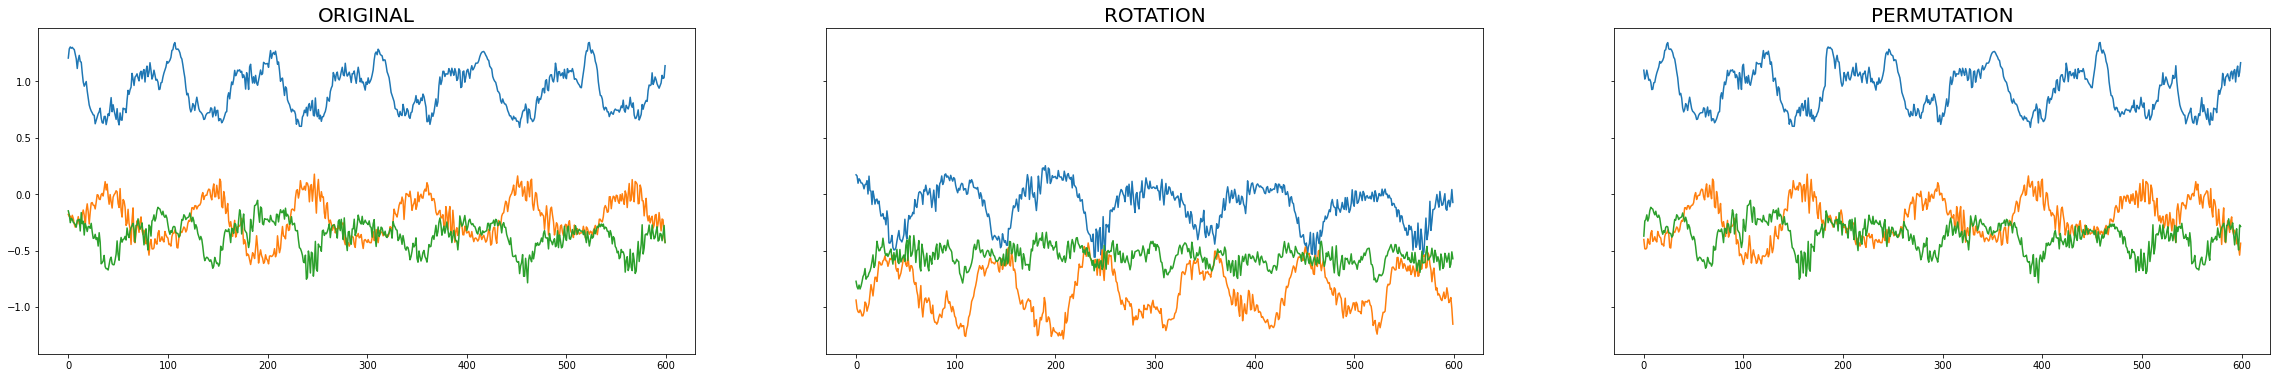

In [11]:
import matplotlib.pyplot as plt

# random.seed => 랜덤성을 제어하기 위한 함수
# 파라미터 그대로 하면 아무리 계속 반복해도 같은 랜덤 수가 나옴
np.random.seed(10)


f, axes = plt.subplots(1, 3, sharex=True, sharey=True)

f.set_size_inches((40, 6))
f.patch.set_facecolor("white")

axes[0].plot(train_acc[:600])
axes[0].set_title("ORIGINAL", fontsize = 20)
axes[1].plot(rotation(train_acc[:600]))
axes[1].set_title("ROTATION", fontsize = 20)
axes[2].plot(permutation(np.array(train_acc[:600])))
axes[2].set_title("PERMUTATION", fontsize = 20)
plt.show()

최종적으로 사용한 데이터 증강 method  
- 짝수 epoch에 rolling, permutation 결합  
- 홀수 epoch에 rolling, rotation 결합

LB public score 기준  
  
- rolling만 사용했을경우 0.51  
- rolling + rotation combine한 경우 0.41  
- 최종적인 aug 방법을 사용한 경우 0.386

### Feature

In [12]:
# display(train)
# display(train.iloc[:, 0]**2)
# display(train.iloc[:, 1]**2)
# (train.iloc[:, 0]**2)+(train.iloc[:, 1]**2)
display(train)
from math import atan, sqrt
print((train.iloc[:,1]/(train.iloc[:,0]**2 + train.iloc[:,2]**2).apply(lambda x : sqrt(x))).apply(lambda x : atan(x))*180/np.pi)
atan(0.776580807892546)*180/np.pi

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
0,0,0,1.206087,-0.179371,-0.148447,-0.591608,-30.549010,-31.676112
1,0,1,1.287696,-0.198974,-0.182444,0.303100,-39.139103,-24.927216
2,0,2,1.304609,-0.195114,-0.253382,-3.617278,-44.122565,-25.019629
3,0,3,1.293095,-0.230366,-0.215210,2.712986,-53.597843,-27.454013
4,0,4,1.300887,-0.187757,-0.222523,4.286707,-57.906561,-27.961234
...,...,...,...,...,...,...,...,...
1874995,3124,595,-0.712530,-0.658357,0.293707,-29.367857,-104.013664,-76.290437
1874996,3124,596,-0.683037,-0.658466,0.329223,-30.149089,-101.796809,-76.625087
1874997,3124,597,-0.664730,-0.666625,0.364114,-27.873095,-98.776072,-79.365125
1874998,3124,598,-0.630534,-0.682565,0.373696,-23.636550,-99.139495,-80.259478


0           0.000000
1          37.832217
2          56.883406
3          66.682429
4          71.984349
             ...    
1874995    10.783455
1874996    10.801152
1874997    10.818848
1874998    10.836541
1874999    10.854232
Length: 1875000, dtype: float64


37.83222741793745

In [13]:
from math import atan, sqrt
from scipy.integrate import cumtrapz

def get_mag(data):
    # data.iloc[ : , 0] => 행은 전체 사용, 열은 0번째만 사용한다
    # 0,1,2번째 컬럼값을 각각 제곱한 뒤 더해서 리턴
    return (data.iloc[:, 0]**2) + (data.iloc[:, 1]**2) + (data.iloc[:, 2]**2)

def get_mul(data):
    # 0,1,2번째 컬럼을 곱한 뒤 리턴
    return data.iloc[:, 0] * data.iloc[:, 1] * data.iloc[:, 2]


##########################################################################################################################

def get_roll_pitch(data):
    # (1번째 컬럼값 / 0번째컬럼값제곱+2번째컬럼값제곱)
    # => 제곱근 => atan => *180 / pi
    roll = (data.iloc[:,1]/(data.iloc[:,0]**2 + data.iloc[:,2]**2).apply(lambda x : sqrt(x))).apply(lambda x : atan(x))*180/np.pi

    # (0번째 컬럼값 / 1번째컬럼값제곱+2번째컬럼값제곱)
    # => 제곱근 => atan => *180 / pi
    pitch = (data.iloc[:,0]/(data.iloc[:,1]**2 + data.iloc[:,2]**2).apply(lambda x : sqrt(x))).apply(lambda x : atan(x))*180/np.pi
    # 두 개의 데이터프레임을 합쳐서 리턴
    return pd.concat([roll, pitch], axis= 1)

##########################################################################################################################

def setting(data, data_, case = 0):
    if case == 0:
        # data의 행 개수까지 600 단위로 반복
        for i in range(0, data.shape[0], 600):
            data[i] = data_[i] - data_[i+599]
    else:
        for i in range(0, data.shape[0], 600):
            # i~i+4번째 원소에 data_의 (i~i+4번째 값 - i+594~i+598번째 값) 대입
            data[i: i+5] = data_[i: i+5].values - data_[i+594:i+599].values
    return data
        
def get_diff(data, case = 0):
    if case == 0:
        # x_dif => data의 0번째 컬럼값을 차분한 값
        # y_dif => data의 1번째 값을 차분한 값
        # z_dif => 2번째 값을 차분한 값
        x_dif, y_dif, z_dif = data.iloc[:, 0].diff(), data.iloc[:, 1].diff(), data.iloc[:, 2].diff()
    else:
        # 5차 차분한 값들을 대입
        # 차분 ex) [1,2,3,4] => [2-1,3-2,4-3] =>[1,1,1]
        x_dif, y_dif, z_dif = data.iloc[:, 0].diff(5), data.iloc[:, 1].diff(5), data.iloc[:, 2].diff(5)
    # 위에서 선언한 setting 함수에 축별_dif, 사용한 컬럼 값을 넣고
    # 반환된 값들을 concat 함수를 이용해서 합친다
    return pd.concat([setting(x_dif, data.iloc[:, 0], case),
                      setting(y_dif, data.iloc[:, 1], case),
                      setting(z_dif, data.iloc[:, 2], case)], axis= 1)
############################################################################################################################

def get_cumtrapz(acc):
    # 변수 선언
    acc_x, acc_y, acc_z = [], [], []
    ds_x, ds_y, ds_z = [], [], []

    # acc => 입력 파라미터
    # acc의 행 수 /600 만큼 반복
    for i in range(int(acc.shape[0]/600)):
        # cumtrapz는 누적사다리꼴 수치를 적분할 때 사용한다..?
        # 이 부분 이해되시는 분은 010-2211-7680 연락 주세요
        acc_x.append(pd.DataFrame(cumtrapz(acc.iloc[600*i:600*(i+1), 0], train_time, initial=0)))
        acc_y.append(pd.DataFrame(cumtrapz(acc.iloc[600*i:600*(i+1), 1], train_time, initial=0)))
        acc_z.append(pd.DataFrame(cumtrapz(acc.iloc[600*i:600*(i+1), 2], train_time, initial=0)))
        ds_x.append(pd.DataFrame(cumtrapz(cumtrapz(acc.iloc[600*i:600*(i+1), 0], train_time, initial=0), train_time, initial=0)))
        ds_y.append(pd.DataFrame(cumtrapz(cumtrapz(acc.iloc[600*i:600*(i+1), 1], train_time, initial=0), train_time, initial=0)))
        ds_z.append(pd.DataFrame(cumtrapz(cumtrapz(acc.iloc[600*i:600*(i+1), 2], train_time, initial=0), train_time, initial=0)))
    return (pd.concat([pd.concat(acc_x), pd.concat(acc_y), pd.concat(acc_z)], axis = 1).reset_index(drop=True),
           pd.concat([pd.concat(ds_x), pd.concat(ds_y), pd.concat(ds_z)], axis= 1).reset_index(drop = True))

 가속도계와 자이로스코프에서 얻을 수 있는 간단한 변수들만을 추가하였습니다.

### Make Dataset

In [14]:
def train_dataset(acc_data, gy_data, i, aug_P = 0):
    # combine_aug 함수에 입력받은 acc_data, aug_P 넘겨서 반환
    aug_acc = combine_aug(acc_data, i, aug_P)
    aug_gy = combine_aug(gy_data, i, aug_P)
    
    # get_diff 함수 수행한 값 반환
    diff_acc = get_diff(aug_acc)
    #diff_acc_5 = get_diff(aug_acc, 1)
    
    # 여기 밑으로는 쭉 함수 사용 및 반환
    roll_pitch_acc = get_roll_pitch(aug_acc)
    mag_acc, mul_acc = get_mag(aug_acc), get_mul(aug_acc)
    # 위에서 선언한 mag_acc, mul_acc concat
    mag_mul_acc = pd.concat([mag_acc, mul_acc], axis= 1)
    #accvel, disp = get_cumtrapz(aug_acc)

    diff_gy = get_diff(aug_gy)
    #diff_gy_5 = get_diff(aug_gy, 1)
    mag_gy, mul_gy = get_mag(aug_gy), get_mul(aug_gy)
    mag_mul_gy = pd.concat([mag_gy, mul_gy], axis= 1)

    return pd.concat([aug_acc, diff_acc, roll_pitch_acc, mag_mul_acc,
                     aug_gy, diff_gy, mag_mul_gy], axis= 1)

def test_dataset(acc_data, gy_data):
    
    diff_acc = get_diff(acc_data)
    #diff_acc_5 = get_diff(acc_data, 1)
    
    roll_pitch_acc = get_roll_pitch(acc_data)
    mag_acc, mul_acc = get_mag(acc_data), get_mul(acc_data)
    mag_mul_acc = pd.concat([mag_acc, mul_acc], axis= 1)
    #accvel, disp = get_cumtrapz(acc_data)

    diff_gy = get_diff(gy_data)
    #diff_gy_5 = get_diff(gy_data, 1)
    mag_gy, mul_gy = get_mag(gy_data), get_mul(gy_data)
    mag_mul_gy = pd.concat([mag_gy, mul_gy], axis= 1)

    return pd.concat([acc_data, diff_acc, roll_pitch_acc, mag_mul_acc,
                      gy_data, diff_gy, mag_mul_gy], axis= 1)

### Scaler

train data만 사용하여 scaler를 만들었습니다.

In [15]:
import sklearn
from sklearn.preprocessing import StandardScaler

data_for_scaler = test_dataset(train_acc, train_gy) # train data만 사용
scaler = StandardScaler().fit(np.array(data_for_scaler))

data_for_scaler = np.array(data_for_scaler).reshape(-1, 600, data_for_scaler.shape[1])
########################################################################################

# acc 값, gy 값으로 나눠서 test_dataset함수 파라미터로 사용
test_x = test_dataset(test.iloc[:, 2:5], test.iloc[:, 5:])

test_X = scaler.transform(np.array(test_x)).reshape(-1, 600, test_x.shape[1])

### Model

이번 대회를 진행하면서 다양한 모델을 시도해 보았습니다. 그 중에 DACON.Dobby님께서 공유해주신 코드를 보고 self attention을 gru와 dense layer사이에 넣어보기도  
하였으나 과적합이 일어나 최종적으로는 gru layer + pooling layer + dense layer를 조합하여 선택했습니다. 개인적인 견해이지만 적은 데이터에는 gru를 사용하는 것이 accuracy와  loss사이의 trade off를 잘 조절해주는 것 같습니다.

In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as L

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession


# 해당 옵션을 True로 설정할 경우, 아래와 같이 GPU의 메모리가 전부 할당되지 않고, 
# 아주 적은 비율만 할당되어 시작해서, 프로세스의 메모리 수요에 따라 증가하게 된다. 
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

최적의 모델을 찾기 위해 파라미터를 수정해 가면서 모니터링한 결과 각각의 모델의 성능은 비슷하나 설명할 수 있는 부분이 살짝 다르다고 판단하여  
각 모델당 2번씩 seed를 다르게 부여하여, 총 8개 결과의 평균을 냈습니다.

In [17]:
def First_model():
    # L => tensorflow.keras.layers
    # data_for_scaler => 위에서 만든 스케일러
    # layers 하위 기능들을 쓰는데 찾기가 너무 힘들다.. 
    inputs = L.Input(shape = (data_for_scaler.shape[1], data_for_scaler.shape[2]))
    gru1 = L.GRU(256, return_sequences = True, dropout = 0.2)(inputs)
    ap = L.AveragePooling1D()(gru1)
    gru2 = L.GRU(150, return_sequences = True)(ap)
    GAP = L.GlobalAveragePooling1D()(gru2)
    dense = L.Dense(61, activation = "softmax")(GAP)
    return keras.models.Model(inputs, dense)

def Second_model():
    inputs = L.Input(shape = (data_for_scaler.shape[1], data_for_scaler.shape[2]))
    gru1 = L.GRU(256, return_sequences = True, dropout = 0.2)(inputs)
    mp = L.MaxPool1D()(gru1)
    ap = L.AveragePooling1D()(gru1)
    concat1 = L.Concatenate()([mp, ap])
    gru2 = L.GRU(150, return_sequences = True, dropout = 0.2)(concat1)
    GAP = L.GlobalAveragePooling1D()(gru2)
    dense = L.Dense(61, activation = "softmax")(GAP)
    return keras.models.Model(inputs, dense)

def Third_model():
    inputs = L.Input(shape = (data_for_scaler.shape[1], data_for_scaler.shape[2]))
    gru1 = L.GRU(256, return_sequences = True, dropout = 0.2)(inputs)
    mp = L.MaxPool1D()(gru1)
    ap = L.AveragePooling1D()(gru1)
    concat1 = L.Concatenate()([mp, ap])
    gru2 = L.GRU(256, return_sequences = True, dropout = 0.2)(concat1)
    GAP = L.GlobalAveragePooling1D()(gru2)
    dense = L.Dense(61, activation = "softmax")(GAP)
    return keras.models.Model(inputs, dense)

def Fourth_model():
    inputs = L.Input(shape = (data_for_scaler.shape[1], data_for_scaler.shape[2]))
    gru1 = L.GRU(256, return_sequences = True, dropout = 0.2)(inputs)
    ap = L.AveragePooling1D()(gru1)
    gru2 = L.GRU(150, return_sequences = True, dropout = 0.2)(ap)
    GAP = L.GlobalAveragePooling1D()(gru2)
    dense = L.Dense(61, activation = "softmax")(GAP)
    return keras.models.Model(inputs, dense)

### Training

In [18]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import random

def train_model(model_ = None, epochs = 40, first_rlr = 15, second_rlr = 30, r_seed = 10, aug_P = 0, seed_ = 1):
    # first_rlr : 첫번째로 learning_rate이 감소
    # second_rlr : 두번째로 learning_rate이 감소
    # r_seed : StratifiedKFold seed
    # seed_ : numpy/random seed
    
    result_model = []
    cnt = 0
    array_acc = np.array(train_acc).reshape(-1, 600, 3)
    array_gy = np.array(train_gy).reshape(-1, 600, 3)
    
    random.seed(seed_)
    tf.random.set_seed(21)

    split = StratifiedKFold(n_splits=10, shuffle = True, random_state = r_seed)
    for train_idx, valid_idx in split.split(data_for_scaler, train_y):
        
        train_Y, valid_Y = np.array(pd.get_dummies(train_y))[train_idx], np.array(pd.get_dummies(train_y))[valid_idx]

        valid_ACC, valid_GY = array_acc[valid_idx].reshape(-1, 3), array_gy[valid_idx].reshape(-1, 3)
        valid_x = test_dataset(pd.DataFrame(valid_ACC), pd.DataFrame(valid_GY))
        valid_X = scaler.transform(np.array(valid_x)).reshape(-1, 600, valid_x.shape[1])

        model = model_()
        model.compile(optimizer=keras.optimizers.RMSprop(0.003),
                      loss='categorical_crossentropy', metrics=['accuracy'])
        val_score = 0
        seed_ += 1

        for i in range(epochs):
            
            np.random.seed(seed_*47 + i)
            
            train_ACC, train_GY = array_acc[train_idx].reshape(-1, 3), array_gy[train_idx].reshape(-1, 3)
            train_x = train_dataset(pd.DataFrame(train_ACC), pd.DataFrame(train_GY), i, aug_P)
            train_X = scaler.transform(np.array(train_x)).reshape(-1, 600, valid_x.shape[1])

            train_X_ = train_X.copy()

            train_X_ = rolling(train_X_)

            hist = model.fit(train_X_, train_Y, epochs = 1, validation_data = (valid_X, valid_Y), verbose = 0)

            train_accuracy = hist.history["accuracy"]
            new_val_score = accuracy_score(np.argmax(valid_Y, axis = 1), np.argmax(model.predict(valid_X), axis = 1))
            val_loss = hist.history["val_loss"]

            if i == first_rlr:
                model.compile(optimizer=keras.optimizers.RMSprop(0.003*0.2),
                              loss='categorical_crossentropy', metrics=['accuracy'])

            if i == second_rlr:
                model.compile(optimizer = keras.optimizers.RMSprop(0.003*0.2*0.4),
                             loss='categorical_crossentropy', metrics=['accuracy'])

            print("epoch {} - train_accuracy : {} - validation_loss : {} - validation_accuracy : {}".format(i,
                                                                                                            train_accuracy,
                                                                                                            val_loss,
                                                                                                            new_val_score,
                                                                                                            ))

            if i == 0:
                val_loss_score = val_loss[0]
        
            if val_loss_score >= val_loss[0]:
                val_loss_score = val_loss[0]
                best_model = model
                print("####best_val####")
                    
            if new_val_score >= val_score:
                val_score = new_val_score
                best_model = model
                print("####best_acc####")
        print("####################################################### cycle {} is done".format(cnt))
        result_model.append(best_model)
        cnt+=1
    return result_model


def predict_(model):
    result = []
    for mod in model:
        result.append(mod.predict(test_X))
    predict = np.array(result).mean(axis = 0)
    return predict

def save_model(models, name = '1'):
    cnt = 1
    for model in models:
        model.save(path + "submission/last/weight/" + name + '-{}.h5'.format(cnt))
        cnt +=1

In [ ]:
first_result = train_model(First_model, r_seed = 47, seed_ = 1)

epoch 0 - train_accuracy : [0.5280938744544983] - validation_loss : [1.6519830226898193] - validation_accuracy : 0.5686900958466453
####best_val####
####best_acc####
epoch 1 - train_accuracy : [0.557965874671936] - validation_loss : [1.4556387662887573] - validation_accuracy : 0.6293929712460063
####best_val####
####best_acc####
epoch 2 - train_accuracy : [0.6561166644096375] - validation_loss : [1.191406488418579] - validation_accuracy : 0.6549520766773163
####best_val####
####best_acc####
epoch 3 - train_accuracy : [0.6358463764190674] - validation_loss : [1.1515812873840332] - validation_accuracy : 0.6837060702875399
####best_val####
####best_acc####
epoch 4 - train_accuracy : [0.7322190403938293] - validation_loss : [0.9856790900230408] - validation_accuracy : 0.7156549520766773
####best_val####
####best_acc####
epoch 5 - train_accuracy : [0.6849217414855957] - validation_loss : [0.8747316598892212] - validation_accuracy : 0.7156549520766773
####best_val####
####best_acc####
epoch 

In [ ]:
second_result = train_model(Second_model, r_seed = 47, seed_ = 5)

In [ ]:
third_result = train_model(First_model, r_seed = 32, seed_ = 9)

In [ ]:
fourth_result = train_model(Second_model, r_seed = 32, seed_ = 13)

In [ ]:
fifth_result = train_model(Third_model, r_seed = 2020, seed_ = 21)

In [ ]:
sixth_result = train_model(Third_model, r_seed = 2020, seed_ = 17)

In [ ]:
seventh_result = train_model(Fourth_model, r_seed = 2020, seed_ = 21)

In [ ]:
eighth_result = train_model(Fourth_model, r_seed = 2020, seed_ = 25)

In [ ]:
##########################################################################################################

### Save Model / Submission

predict 과정에서 역시 Dobby님께서 공유해주신 TTA를 적용해 보았으나 public score가 감소하여 사용하진 않았습니다.  
아마 제가 구현하는 과정에서 오류가 있었던 것으로 보입니다.

In [ ]:
#save_model(first_result)
submission.iloc[:, 1:] = predict_(first_result)
submission1 = submission
#submission1.to_csv(path + "submission/last/1.csv", index = False)

#save_model(second_result, "2")
submission.iloc[:, 1:] = predict_(second_result)
submission2 = submission
#submission2.to_csv(path + "submission/last/2.csv", index = False)

#save_model(third_result, "3")
submission.iloc[:, 1:] = predict_(third_result)
submission3 = submission
#submission3.to_csv(path + "submission/last/3.csv", index = False)

#save_model(fourth_result, "4")
submission.iloc[:, 1:] = predict_(fourth_result)
submission4 = submission
#submission4.to_csv(path + "submission/last/4.csv", index = False)

#save_model(fifth_result, "5")
submission.iloc[:, 1:] = predict_(fifth_result)
submission5 = submission
#submission5.to_csv(path + "submission/last/5.csv", index = False)

#save_model(sixth_result, "6")
submission.iloc[:, 1:] = predict_(sixth_result)
submission6 = submission
#submission6.to_csv(path + "submission/last/6.csv", index = False)

#save_model(seventh_result, "7")
submission.iloc[:, 1:] = predict_(seventh_result)
submission7 = submission
#submission7.to_csv(path + "submission/last/7.csv", index = False)

#save_model(eighth_result, "8")
submission.iloc[:, 1:] = predict_(eighth_result)
submission8 = submission
#submission8.to_csv(path + "submission/last/8.csv", index = False)

In [ ]:
#submission1 = pd.read_csv(path + "submission/last/1.csv")
#submission2 = pd.read_csv(path + "submission/last/2.csv")
#submission3 = pd.read_csv(path + "submission/last/3.csv")
#submission4 = pd.read_csv(path + "submission/last/4.csv")
#submission5 = pd.read_csv(path + "submission/last/5.csv")
#submission6 = pd.read_csv(path + "submission/last/6.csv")
#submission7 = pd.read_csv(path + "submission/last/7.csv")
#submission8 = pd.read_csv(path + "submission/last/8.csv")

In [ ]:
submission.iloc[:, 1:] = (submission1.iloc[:, 1:]/8 + submission2.iloc[:, 1:]/8 +
                         submission3.iloc[:, 1:]/8 + submission4.iloc[:, 1:]/8 +
                         submission5.iloc[:, 1:]/8 + submission6.iloc[:, 1:]/8 +
                         submission7.iloc[:, 1:]/8 + submission8.iloc[:, 1:]/8)

In [ ]:
#submission.to_csv(path + "submission/last/95.csv", index = False)